![](https://monkeylearn.com/static/6700dcab9bcc691104dd0d794f6e7ef4/Sentiment-analysis-of-Twitter-Social.png)

### <b><span style='color:#F1A425'>Test Classification</span></b>

- Text classification is one of the most common tasks in NLP
- It can be used for a wide range of applications (eg. tagging customer feedback into categories, routing support tickets according to their language)
- Another common type of text classification problem is **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">sentiment analysis</mark>** which aims to **identify the polatity** of a given text (+/-)

### <b><span style='color:#F1A424'>Our Task</span></b>

- We need to build a system that will be able to automatically identify emotional states (eg. anger, joy) that people express about your company's product on twitter

<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'>1 |</span></span></b>Import Libraries</b></p></div>

In [2]:
import pandas as pd
import numpy as np 
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']

train = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",
                    sep=',',names=column_names)


validation = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv",
                    sep=',',names=column_names)

In [4]:
train.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
validation.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'>2 |</span></span></b> EDA</b></p></div>


    
- Many data sets involving **sentiment** analysis are **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">binary</mark>** classification problems 
- In this dataset we have **4 different sentiments**, which means we'll be treating this problem as a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">multiclass</mark>** classification problem

In [6]:
# information of the dataset
print(f"Train dataset shape {train.shape}")
print(f"Validation dataset shape {validation.shape}")

Train dataset shape (74682, 4)
Validation dataset shape (1000, 4)


In [7]:
# checking nan values 
print("\t\t\tTrain dataset")
print(train.isna().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.isna().sum())

			Train dataset
Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64
****************************************
			Validation dataset
Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64


In [8]:
# checking duplicated values
print("\t\t\tTrain dataset")
print(train.duplicated().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.duplicated().sum())

			Train dataset
2700
****************************************
			Validation dataset
0


In [9]:
# remove dupicate and nan values
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [10]:
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojilar
                               u"\U0001F300-\U0001F5FF"  # simvollar va diagrammalar
                               u"\U0001F680-\U0001F6FF"  # transport va turli joylar
                               u"\U0001F1E0-\U0001F1FF"  # davlat bayroqlari
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # alamatchilik belgilari
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [11]:
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_emojis(x))
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_urls(x))

validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_emojis(x))
validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_urls(x))

In [12]:
train['text_lens']=train['Tweet_content'].apply(lambda x: len(x))
validation['text_lens']=validation['Tweet_content'].apply(lambda x: len(x))

<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'>2 |</span></span></b> Data Visualition</b></p></div>

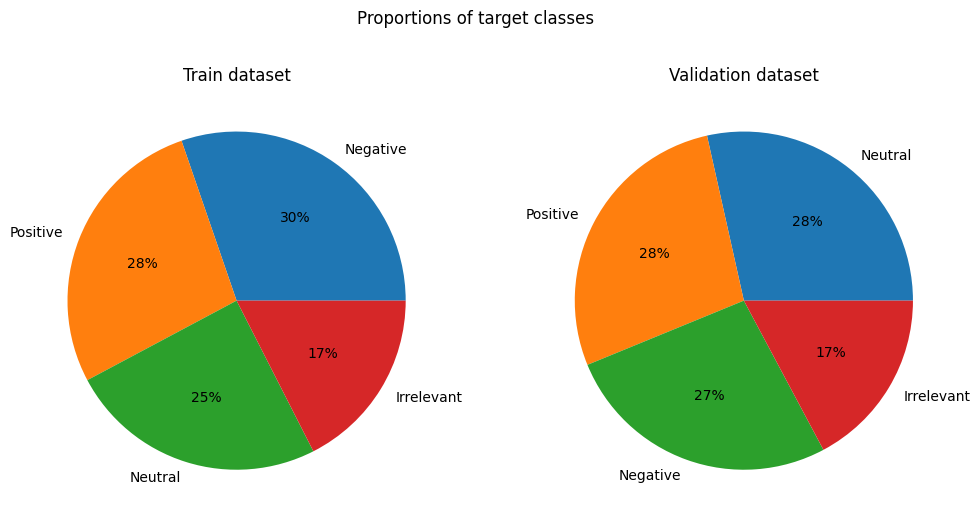

In [13]:
fig , ax = plt.subplots(1,2,figsize=(12,6))

ax[0].pie(train['Sentiment'].value_counts(),labels=train['Sentiment'].value_counts().index,autopct='%.f%%')
ax[1].pie(validation['Sentiment'].value_counts(),labels=validation['Sentiment'].value_counts().index,autopct='%.f%%')

fig.suptitle("Proportions of target classes")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

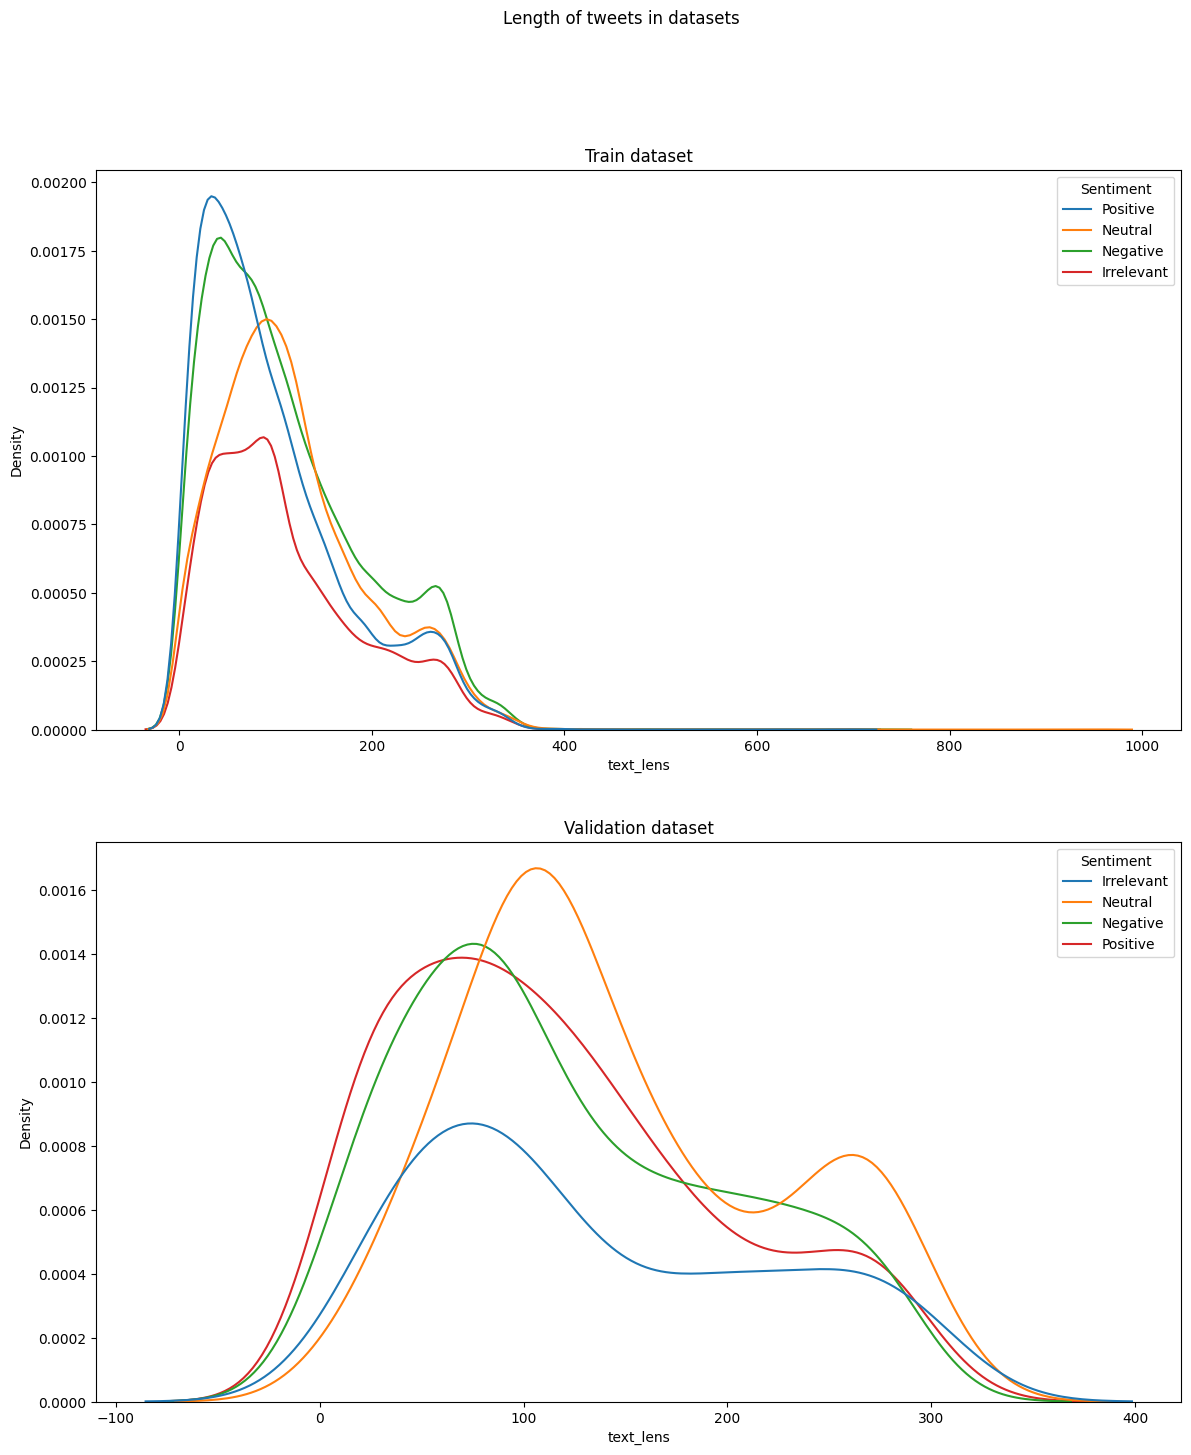

In [14]:
fig ,ax = plt.subplots(2,1,figsize=(14,16))

sns.kdeplot(data=train,x='text_lens',hue='Sentiment',ax=ax[0])
sns.kdeplot(data=validation,x='text_lens',hue='Sentiment',ax=ax[1])

fig.suptitle("Length of tweets in datasets")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

In [15]:
#Count information per category
data1=train.groupby(by=["Entity","Sentiment"]).count().reset_index()
data1.head()

,Entity,Sentiment,Tweet_ID,Tweet_content,text_lens
0,Amazon,Irrelevant,185,185,185
1,Amazon,Negative,565,565,565
2,Amazon,Neutral,1197,1197,1197
3,Amazon,Positive,302,302,302
4,ApexLegends,Irrelevant,185,185,185


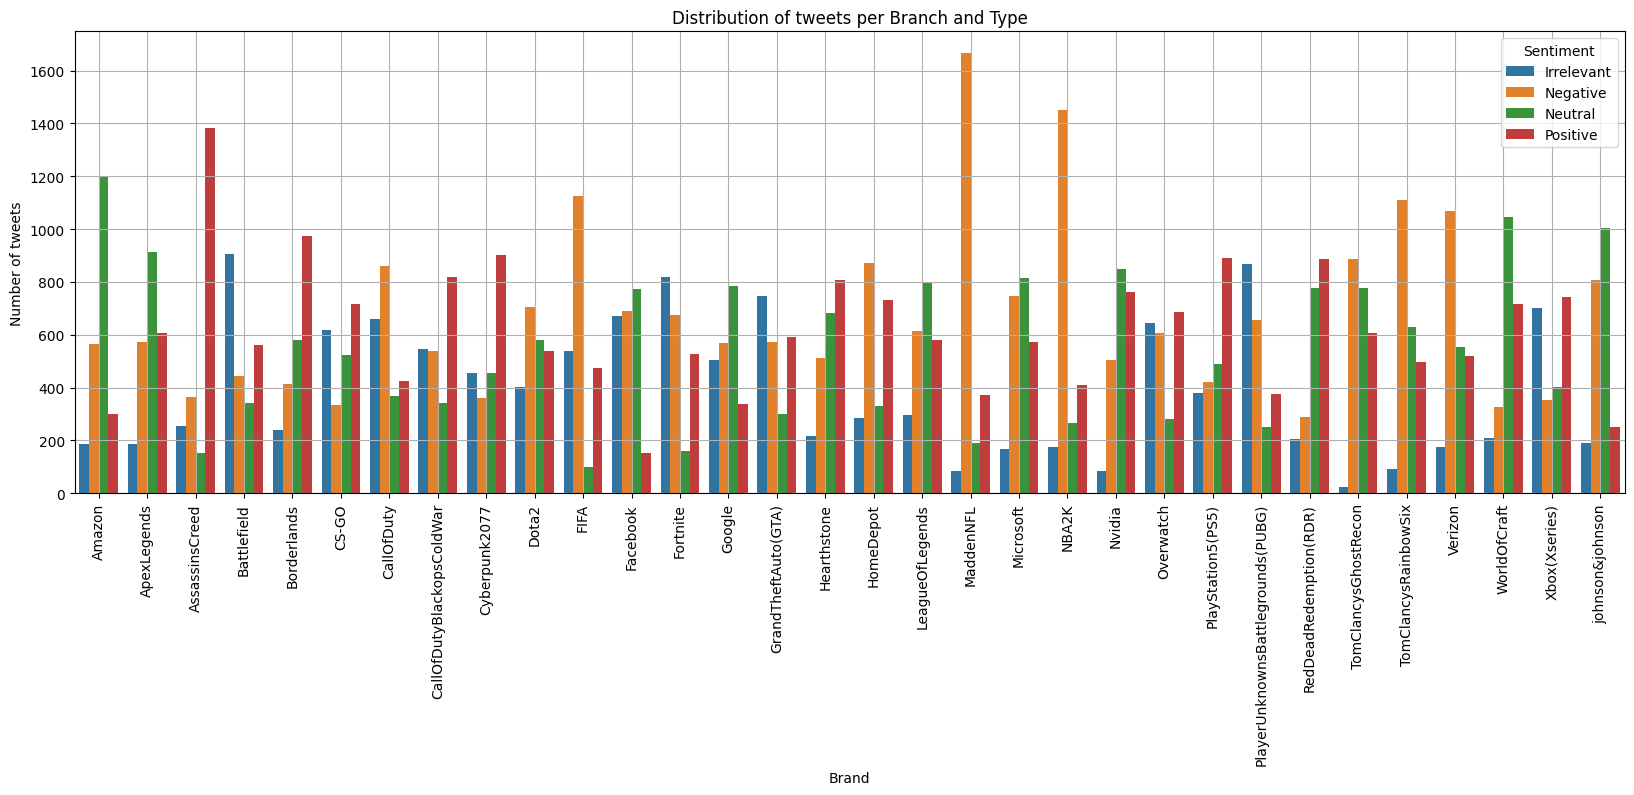

In [16]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=data1,x="Entity",y="Tweet_ID",hue='Sentiment')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")
plt.show()

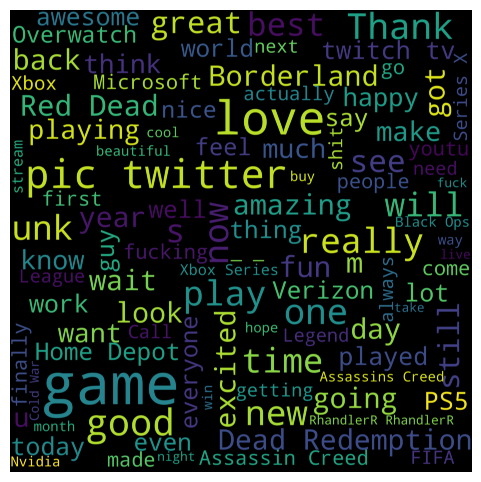

In [17]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Positive"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

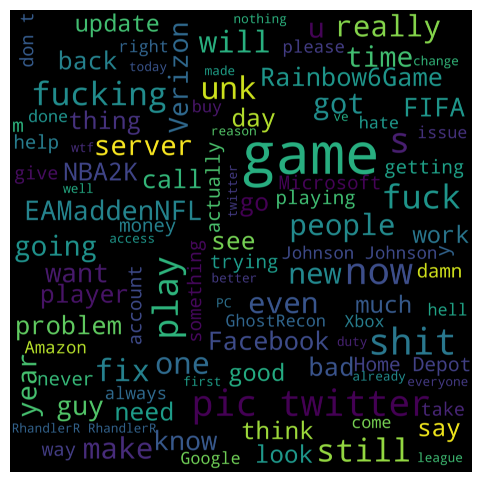

In [18]:
word_cloud_text_negative = ''.join(train[train["Sentiment"]=="Negative"].Tweet_content)
wordcloud_negative = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text_negative)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.show()

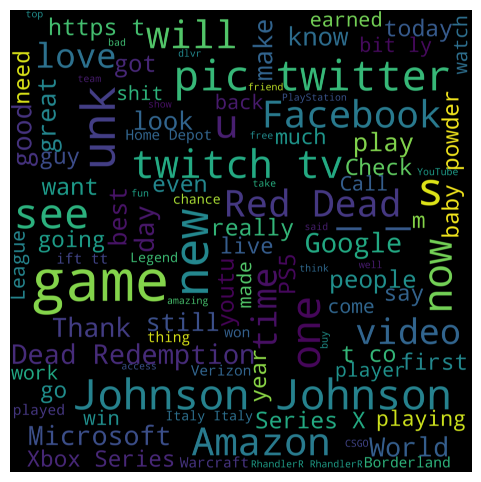

In [19]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Neutral"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

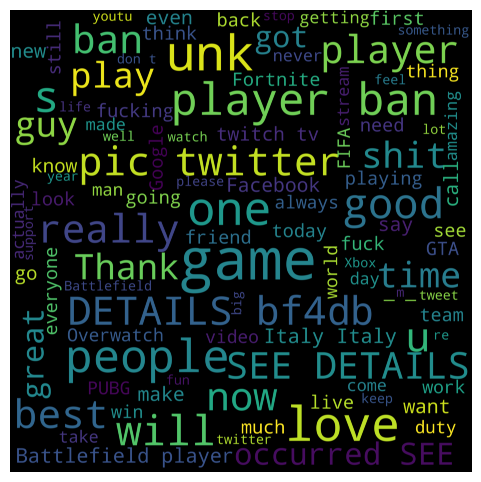

In [20]:
word_cloud_text = ''.join(train[train["Sentiment"]=="Irrelevant"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

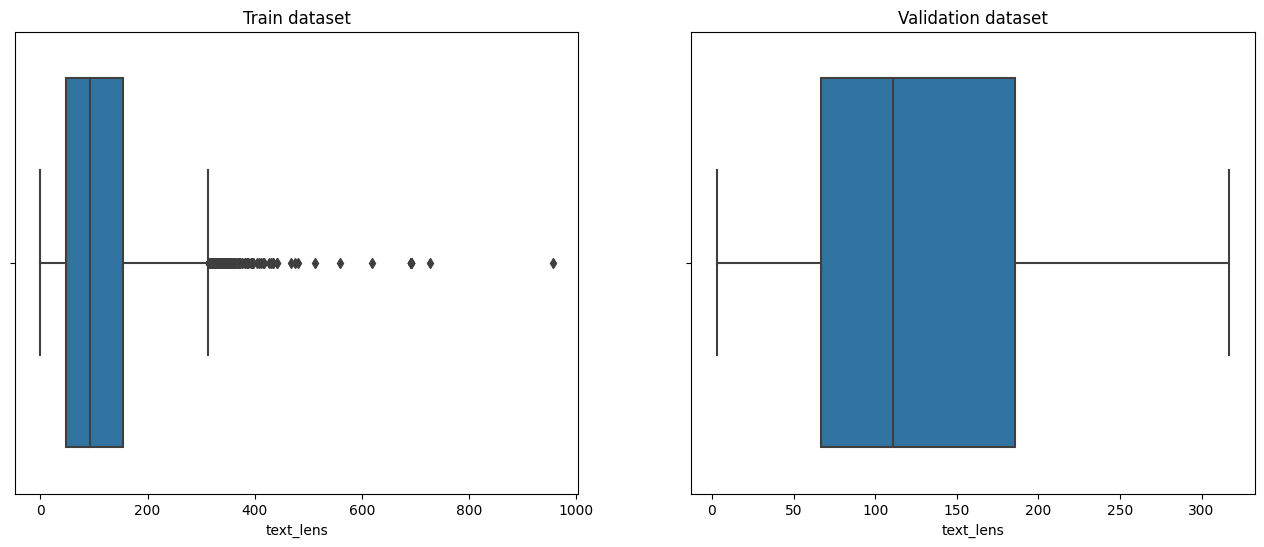

In [21]:
fig , ax = plt.subplots(1,2,figsize=(16,6))

sns.boxplot(data=train,x='text_lens',ax=ax[0])
sns.boxplot(data=validation,x='text_lens',ax=ax[1])

ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'> 3 | </span></span></b> Data Preprocessing </b></p></div>

## <b>3.1 <span style='color:#F1A424'>|</span> Data Cleaning</b> 

In [22]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
train = remove_outlier(train,'text_lens')

## <b>3.2 <span style='color:#F1A424'>|</span> Tokenazation and  Lemmatization</b> 

In [23]:
nlp=spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    

train['preprocessed_text']=train['Tweet_content'].apply(lambda x: preprocess(x))
validation['preprocessed_text']=validation['Tweet_content'].apply(lambda x: preprocess(x))

## <b>3.3 <span style='color:#F1A424'>|</span> Train Test Split</b> 

In [24]:
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train, y_test = train_test_split(
    train[['preprocessed_text']],
    train[['Sentiment']],
    test_size=0.2,
    random_state=42
)

## <b>3.4 <span style='color:#F1A424'>|</span> Data Representation</b> 
- In this step, we will convert text from text to vector

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect= vectorizer.transform(X_test['preprocessed_text'])

y_train=y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})
y_test=y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

In [26]:
validation_X = vectorizer.transform(validation['preprocessed_text'])
validation_y = validation['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

<div style="color:white;display:fill;border-radius:8px;background-color:#323232;font-size:150%; letter-spacing:1.0px"><p style="padding: 12px;color:white;"><b><b><span style='color:white'><span style='color:#F1A424'> 4 | </span></span></b> Machine Learning </b></p></div>

- We test in this step **ML Models**
- We test three different **ML Models**


## <b>4.1 <span style='color:#F1A424'>|</span> MultinomialNB</b> 

In [27]:
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      3900
           1       0.65      0.89      0.75      4238
           2       0.84      0.64      0.73      3518
           3       0.94      0.44      0.60      2516

    accuracy                           0.72     14172
   macro avg       0.78      0.69      0.70     14172
weighted avg       0.76      0.72      0.72     14172



## <b>4.2 <span style='color:#F1A424'>|</span> RandomForestClassifier</b> 

In [28]:
model = RandomForestClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3900
           1       0.92      0.92      0.92      4238
           2       0.93      0.89      0.91      3518
           3       0.97      0.85      0.91      2516

    accuracy                           0.91     14172
   macro avg       0.92      0.90      0.91     14172
weighted avg       0.91      0.91      0.91     14172



## <b>4.3 <span style='color:#F1A424'>|</span> ExtraTreesClassifier</b> 

In [29]:
model_extra = ExtraTreesClassifier()
model_extra.fit(X_train_vect,y_train)
y_predict= model_extra.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3900
           1       0.94      0.93      0.94      4238
           2       0.95      0.91      0.93      3518
           3       0.98      0.88      0.93      2516

    accuracy                           0.92     14172
   macro avg       0.93      0.92      0.92     14172
weighted avg       0.93      0.92      0.92     14172



## <b>4.4 <span style='color:#F1A424'>|</span> Validation Test</b> 

In [30]:
y_predict= model_extra.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       277
           1       0.94      0.97      0.96       266
           2       0.97      0.96      0.97       285
           3       0.98      0.94      0.96       172

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

